In [1]:
""" やること
1. エンコードされたtrain.csv, test.csvの作成(ツリーモデル用)
"""
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy import stats
import category_encoders as ce
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

"""
各種設定
"""
pd.set_option('display.max_columns', 100)
RANDOM_STATE = 2020
MAKE_TARGET_ENCODED_DATA = True
MAKE_ORD_ENCODED_DATA = True  # OrdEncodeに実装
LOAD_NUM = 600000    # 5万データのみ読み込み

In [2]:
"""
関数定義
"""

def plotting_cat_fet(df, cols, vis_row=5, vis_col=2):
    
    grid = gridspec.GridSpec(vis_row,vis_col) # The grid of chart
    plt.figure(figsize=(17, 35))

    # loop to get column and the count of plots
    for n, col in tqdm(enumerate(df[cols])): 
        tmp = pd.crosstab(df[col], df['target'], normalize='index') * 100
        tmp = tmp.reset_index()
        tmp.rename(columns={0:'No',1:'Yes'}, inplace=True)

        ax = plt.subplot(grid[n]) # feeding the figure of grid
        sns.countplot(x=col, data=df, order=list(tmp[col].values) , color='green') 
        ax.set_ylabel('Count', fontsize=15) # y axis label
        ax.set_title(f'{col} Distribution by Target', fontsize=18) # title label
        ax.set_xlabel(f'{col} values', fontsize=15)

        # twinX - to build a second yaxis
        gt = ax.twinx()
        gt = sns.pointplot(x=col, y='Yes', data=tmp,
                           order=list(tmp[col].values),
                           color='black', legend=False)
        gt.set_ylim(tmp['Yes'].min()-5,tmp['Yes'].max()*1.1)
        gt.set_ylabel("Target %True(1)", fontsize=16)
        sizes=[] # Get highest values in y
        for p in ax.patches: # loop to all objects
            height = p.get_height()
            sizes.append(height)
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}%'.format(height/len(df)*100),
                    ha="center", fontsize=14) 
        ax.set_ylim(0, max(sizes) * 1.15)

    plt.subplots_adjust(hspace = 0.5, wspace=.3)
    plt.show()
    
def get_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def count_plot(data_series):
    values = data_series.value_counts()
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    barplot = plt.bar(values.index, values, color='lightgreen', alpha=0.8)
    barplot[1].set_color('darkred')
    
    ax.set_title('Target Distribution')
    ax.annotate("percentage of target 1 : {}%".format(values.sum() / len(values)),
                xy=(0, 0), xycoords='axes fraction',
                xytext=(0, -50), textcoords='offset points',
                va="top", ha="left", color='grey',
                bbox=dict(boxstyle='round', fc="w", ec='w'))
    
    plt.xlabel('Target', fontsize=12, weight='bold')
    plt.show()

def plot_roc(y_true, y_pred, model_name):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    print("%s: %s" % (model_name, auc(fpr, tpr)))
    plt.title(model_name)
    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('FPR: False positive rate')
    plt.ylabel('TPR: True positive rate')
    plt.grid()
    plt.show()

In [3]:
"""
データの読み込み
train, test, sample_submission 
"""

train = pd.read_csv("../../../cat-in-the-dat-ii/input/train.csv", index_col=0)[:LOAD_NUM].sort_index(inplace=False)
test = pd.read_csv("../../../cat-in-the-dat-ii/input/test.csv", index_col=0)[:LOAD_NUM].sort_index(inplace=False)
sample_submission = pd.read_csv("../../../cat-in-the-dat-ii/input/sample_submission.csv", index_col=0)

# 編集用に複製
train_X, train_y = train.drop(['target'], axis=1), train['target']
test_X = test

In [4]:
"""
特徴生成 & 特徴選択
"""
# 不要なカラムの削除
train_X.drop(['ord_3'], axis=1, inplace=True)
test_X.drop(['ord_3'], axis=1, inplace=True)

# ord_5 １文字目、２文字目
train_X['ord_5_first'] = train_X['ord_5'].str[0]
train_X['ord_5_second'] = train_X['ord_5'].str[1]
test_X['ord_5_first'] = test_X['ord_5'].str[0]
test_X['ord_5_second'] = test_X['ord_5'].str[1]

# ord_5 １文字目、２文字目の大文字
train_X['ord_5_first_upper'] = train_X['ord_5_first'].str.upper()
test_X['ord_5_first_upper'] = test_X['ord_5_first'].str.upper()
train_X['ord_5_second_upper'] = train_X['ord_5_second'].str.upper()
test_X['ord_5_second_upper'] = test_X['ord_5_second'].str.upper()


In [5]:
# ランダムを追加してみる(100カテゴリ)
data = np.random.randint(low=1, high=100, size=(1, len(train_X))).flatten()
train_X['random_100'] = pd.Series(data, index=train_X.index)
test_X['random_100'] = pd.Series(data, index=train_X.index)

In [6]:
"""
------------------------- データ分析 -------------------------
"""

train_summary = get_summary(train)

Dataset Shape: (600000, 24)


5it [00:01,  4.83it/s]


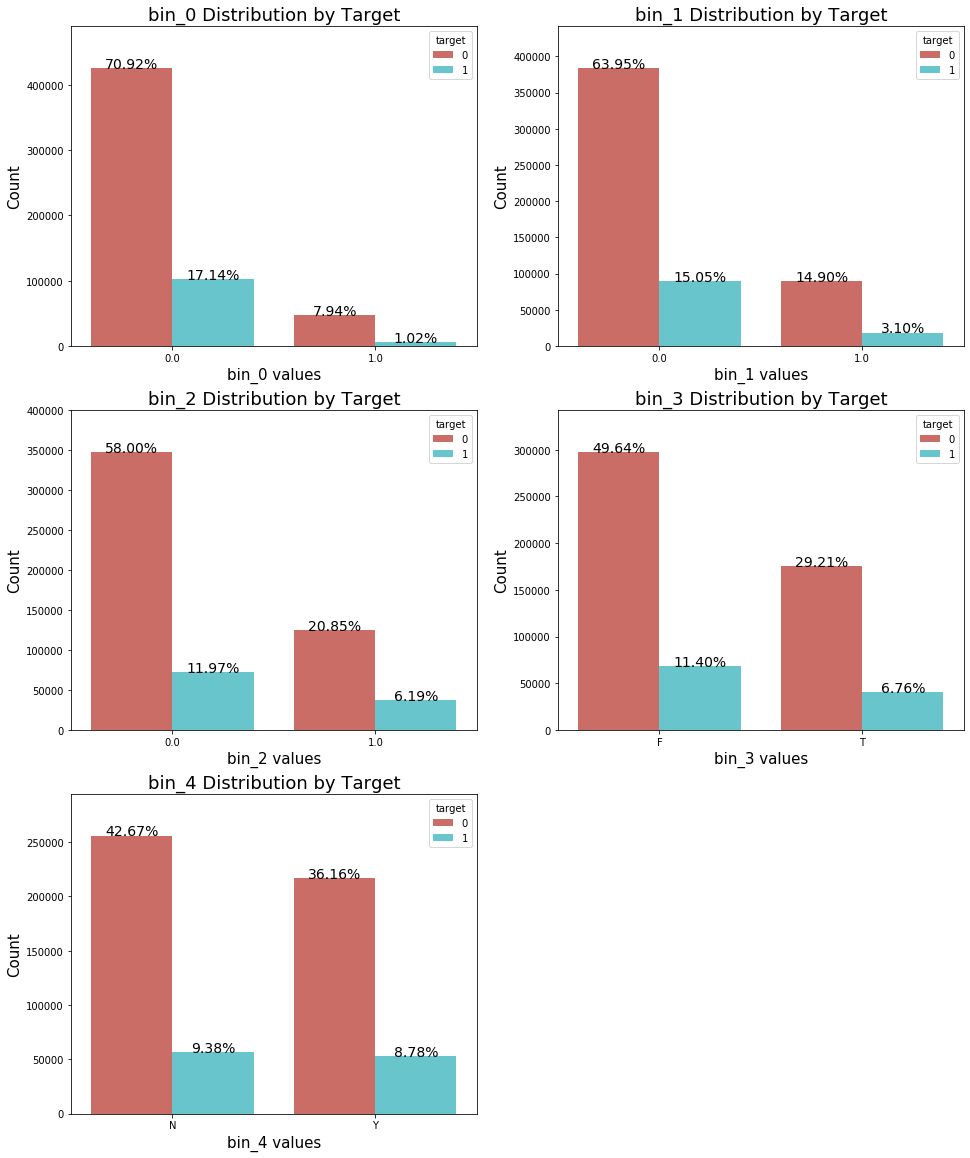

In [7]:
""" 
バイナリカテゴリの分布 
"""

bin_cols = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',] 
grid = gridspec.GridSpec(3, 2) # The grid of chart
plt.figure(figsize=(16,20))

# loop to get column and the count of plots
for n, col in tqdm(enumerate(train[bin_cols])): 
    ax = plt.subplot(grid[n])
    sns.countplot(x=col, data=train, hue='target', palette='hls') 
    ax.set_ylabel('Count', fontsize=15)
    ax.set_title(f'{col} Distribution by Target', fontsize=18)
    ax.set_xlabel(f'{col} values', fontsize=15)
    sizes=[]
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/len(train)*100),
                ha="center", fontsize=14) 
    ax.set_ylim(0, max(sizes) * 1.15)
    
plt.show()

In [8]:
train_df = pd.concat([train_X, train_y], axis=1)

5it [00:01,  2.61it/s]


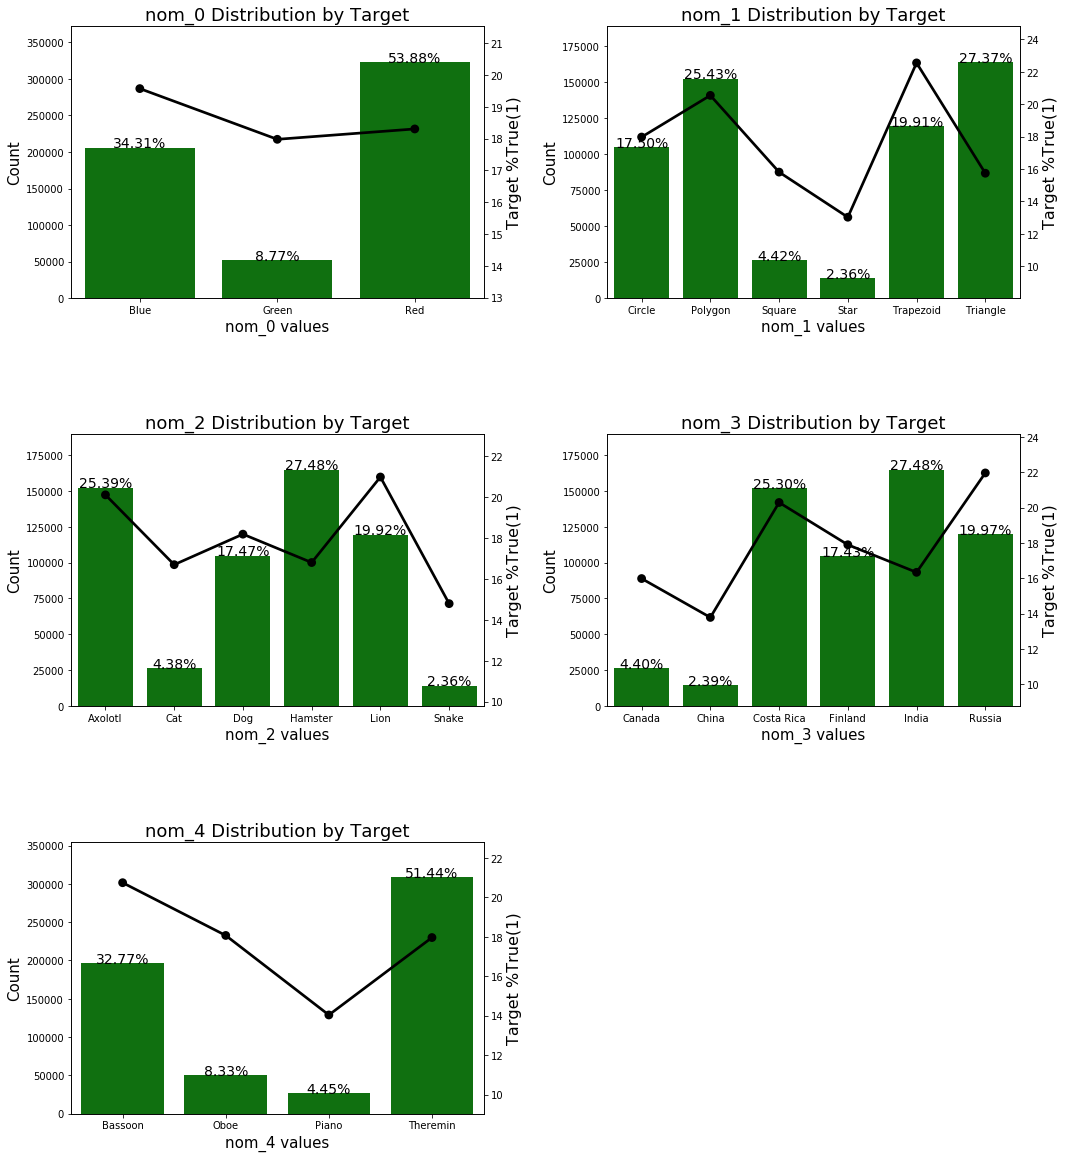

In [9]:
# nom_6以降はユニークが多すぎる
nom_cols = [f'nom_{i}' for i in range(5)]
# nom_cols.append('day')
# nom_cols.append('month')
# nom_cols.append('ord_0')
# nom_cols.append('ord_1')
# nom_cols.append('ord_2')

plotting_cat_fet(train_df, cols=nom_cols)


In [10]:
print(train_X['ord_5_first'].nunique())
print(train_X['ord_5_first_upper'].nunique())
print(train_X['ord_5_second'].nunique())
print(train_X['ord_5_second_upper'].nunique())
print(train_X['ord_5'].nunique())


51
26
50
26
190


In [11]:
rate_df_dict = {}
firsts = ['ord_5', 'ord_5_first', 'ord_5_first_upper']
seconds = ['ord_5', 'ord_5_second', 'ord_5_second_upper']
for col in firsts:
    temp_df = train_df[[col, 'target']].groupby(by=col).mean()
    temp_df.sort_index(inplace=True)
    rate_df_dict[col] = temp_df.T


'\n----------------------------- データ分析 -----------------------------\n'

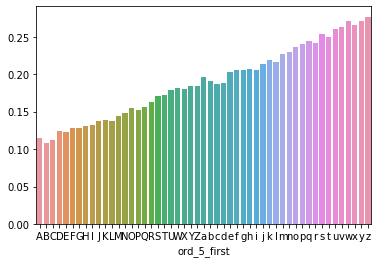

In [12]:
sns.barplot(data=rate_df_dict['ord_5_first'])

"""
----------------------------- データ分析 -----------------------------
"""

In [13]:
"""
ターゲットエンコーディング
"""

# ターゲットエンコーディング
skf = StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
smoothing = 0.20

#  trainデータをエンコード
oof = pd.DataFrame([])
for tr_index, oof_index in tqdm(skf.split(train_X, train_y)):
    ce_target_encoder = ce.TargetEncoder(smoothing=smoothing, cols=list(train_X.columns))
    ce_target_encoder.fit(train_X.iloc[tr_index, :], train_y.iloc[tr_index])
    oof_part = ce_target_encoder.transform(train_X.iloc[oof_index, :])
    oof = oof.append(oof_part, ignore_index=False)

# testデータをエンコード
ce_target_encoder = ce.TargetEncoder(smoothing=smoothing, cols=list(train_X.columns))
ce_target_encoder.fit(train_X, train_y)
train_X = oof.sort_index()
test_X = ce_target_encoder.transform(test_X, override_return_df=True)


5it [00:44,  8.86s/it]


In [14]:
"""
序数変数のエンコード
(単純に階級を数字に置き換えているだけ)
"""

if MAKE_ORD_ENCODED_DATA:
    # OrdEncode.ipynbに実装
    pass
else:
    # id列をindexとして指定しないと、test側でindexが0から連番となり、nanが代入されるため注意
    # 詳細はwikiに記載
    ord_columns = ['id', 'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4']
    train_temp = pd.read_csv("../../../cat-in-the-dat-ii/output/datas/train_ord.csv", usecols=ord_columns, index_col=0)
    test_temp = pd.read_csv("../../../cat-in-the-dat-ii/output/datas/test_ord.csv", usecols=ord_columns, index_col=0)
    ord_columns.remove('id')
    train_X[ord_columns] = train_temp
    test_X[ord_columns] = test_temp

    # 不要な変数を削除
    del train_temp
    del test_temp

In [15]:
"""
データの保存
"""
if len(train_X) < 600000 and len(test_X) < 400000:
    pd.concat([train_X, train_y], axis=1).to_csv("../../../cat-in-the-dat-ii/output/datas/train_tree_mini.csv") 
    test_X.to_csv("../../../cat-in-the-dat-ii/output/datas/test_tree_mini.csv")
    print('ミニデータを保存しました')
else:
    pd.concat([train_X, train_y], axis=1).to_csv("../../../cat-in-the-dat-ii/output/datas/train_tree.csv") 
    test_X.to_csv("../../../cat-in-the-dat-ii/output/datas/test_tree.csv")
    print('本番データ保存しました')

本番データ保存しました
